# GRAPH & NODE2VEC

1. Node2Vec 기반 Similarity Recommendation
2. H&M 데이터셋으로 추천시스템을 직접 구축해 봅시다.



In [1]:
# 필요한 모든 라이브러리 임포트

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import random

H&M Personalized Fashion Recommendations 데이터셋은, Kaggle에서 2023년 3월 15일 ~ 6월 14일 동안 진행된 대회 데이터셋이랍니다.   
이번에 사용할 데이터셋은 그 중에서도 transactions와 articles, images 3개에요.  
transactions 데이터셋에는 유저가 아이템을 구매한 기록이 담겨 있고, articles에는 아이템 정보가 담겨 있어요.   
images에는 아이템 상품의 이미지가 저장되어 있습니다.

data link : https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data

In [3]:
# H&M 데이터셋 로드
folder_path = "data/"
articles_path = folder_path + "articles.csv"
transactions_path = folder_path + "transactions_train.csv"

articles = pd.read_csv(articles_path)
transactions = pd.read_csv(transactions_path)

## Data Preprocessing

- sparse함을 최대한 줄이기 위해 유의미한 row들만 남긴다. 
- article_id와 customer_id를 빈도별로 계산하고 구매한 기록이 많은 유저와 구매된 기록이 많은 제품만을 고려해 필터링

In [5]:
# 아이템과 사용자에 대한 빈도를 계산합니다.
item_freq = transactions.groupby(
    'article_id')['customer_id'].nunique()  # 아이템별로 몇 명의 고객이 구매했는지
user_freq = transactions.groupby('customer_id')[
    'article_id'].nunique()  # 사용자별로 몇 개의 아이템을 구매했는지

# 빈도가 100회 이상인 아이템과 사용자만 선택합니다.
items = item_freq[item_freq >= 100].index
users = user_freq[user_freq >= 100].index

# 선택된 아이템과 사용자에 해당하는 행만 남깁니다.
filtered_df = transactions[transactions['article_id'].isin(
    items) & transactions['customer_id'].isin(users)]

## Edge Weight

In [13]:
# weight 추가를 위한 집계
# 'customer_id'와 'article_id' 쌍별로 등장하는 빈도를 계산합니다.
freq = filtered_df.groupby(
    ['customer_id', 'article_id']).size().reset_index(name='frequency')

# 'frequency' column을 추가합니다.
GraphTravel_HM = filtered_df.merge(
    freq, on=['customer_id', 'article_id'], how='left')

# 'frequency'가 10 이상인 행만 df에 남깁니다.
GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

In [14]:
display(GraphTravel_HM)

print("unique customer_id", GraphTravel_HM.customer_id.nunique())
print("unique article_id", GraphTravel_HM.article_id.nunique())

,t_dat,customer_id,article_id,price,sales_channel_id,frequency
194,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
195,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
196,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
1181,2018-09-20,1f58e8b3be25c4ca4bb457902f911cfbd4ed3a3f502685...,228257001,0.006763,2,19
1182,2018-09-20,1f58e8b3be25c4ca4bb457902f911cfbd4ed3a3f502685...,228257001,0.006797,2,19
...,...,...,...,...,...,...
6998469,2020-09-22,03fdb0bf2d9ff8ba23e1b4aef53709119aad5bc83691d8...,554450043,0.033881,2,18
6998949,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11
6998950,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012915,2,11
6998951,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11


unique customer_id 1013
unique article_id 922


/var/folders/d8/hf3bvhxj15d7kf2qjl67237c0000gn/T/ipykernel_92332/1066616564.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)


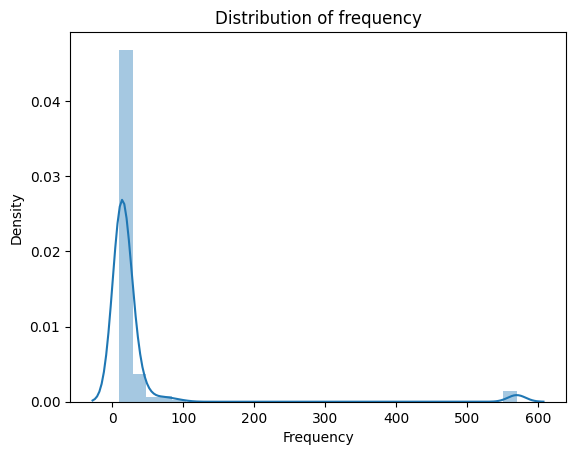

In [15]:
# frequency column의 히스토그램 및 KDE 그래프를 그립니다.
sns.distplot(GraphTravel_HM["frequency"], kde=True, bins=30)

plt.title("Distribution of frequency")
plt.xlabel("Frequency")
plt.ylabel("Density")

plt.show()

In [18]:
# 해시값인 customer_id 정수 매핑
unique_customer_ids = GraphTravel_HM['customer_id'].unique()
customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(
    customer_id_mapping)

# article_id를 prod_name에 매핑하는 dictionary를 생성
item_name_mapping = dict(
    zip(articles['article_id'], articles['prod_name']))  # prod_name

## Make Graph

In [24]:
# 그래프 초기화
G = nx.Graph()

# 노드와 엣지를 추가
for index, row in GraphTravel_HM.iterrows():
    G.add_node(row['customer_id'], type='user')
    G.add_node(row['article_id'], type='item')

    # 'customer_id'와 'article_id' 사이에 가중치가 'frequency'인 엣지를 추가
    G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

# biased random walk 코드


def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter : 방문한 적 있는 노드로 돌아갈 확률 제어
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter : 타겟 노드의 이웃 노드로 이동할 확률 1
                        probability.append(1)
                    else:
                        # In-out parameter : 타겟 노드의 이웃이 아닌 노드로 이동할 확률 제어
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk


def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

In [25]:
# Random Walk 생성
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)

# walks는 random walk 결과를 담은 리스트라고 가정
filtered_walks = [walk for walk in walks if len(walk) >= 5]

# String 형태로 변환 (Word2Vec 입력을 위해)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec 학습
model = Word2Vec(walks, vector_size=128, window=5,
                 min_count=0,  hs=1, sg=1, workers=4, epochs=10)

# 노드 임베딩 추출
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}

## Node2Vec Recommendation 

In [26]:
def get_user_embedding(user_id, embeddings):
    '''
    유저 node의 embedding을 반환
    '''
    return embeddings[str(user_id)]

def get_rated_items(user_id, df):
    '''
    유저가 이미 평가한 아이템 리스트를 반환합니다. 
    이 정보는 이미 구매한 아이템을 추천에서 제외하기위해 사용
    '''
    return set(df[df['customer_id'] == user_id]['article_id'])


def calculate_similarities(user_id, df, embeddings):
    '''
    모든 유저와 모든 아이템 간의 유사도를 계산 
    '''
    rated_items = get_rated_items(user_id, df)
    user_embedding = get_user_embedding(user_id, embeddings)

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items:  # 이미 구매한 제품은 제외
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities


def show_images(items, item_name_mapping, num_items, show_similarity=False):
    # True로 설정되면, 아이템의 similarity score도 함께 출력됩니다!
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()
    
def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    # 사용자가 이미 구매한 제품 찾기
    rated_items = get_rated_items(user_id, df)
    
    # 사용자가 구매한 아이템의 이미지 출력
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))
    
    # 각 아이템 노드에 대한 유사도를 계산
    item_similarities = calculate_similarities(user_id, df, embeddings)

    # 유사도가 가장 높은 아이템들을 추천
    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


User 45 has purchased:
- Item 598811011: Dingo tank
Image for item 598811011 not found.
- Item 189616006: Heavy jsy long leg
Image for item 189616006 not found.
- Item 598517002: SANDY shorts
Image for item 598517002 not found.
- Item 633808016: Terrier tee TOP PRODUCT
Image for item 633808016 not found.
- Item 443696021: BO basic OH BB
Image for item 443696021 not found.


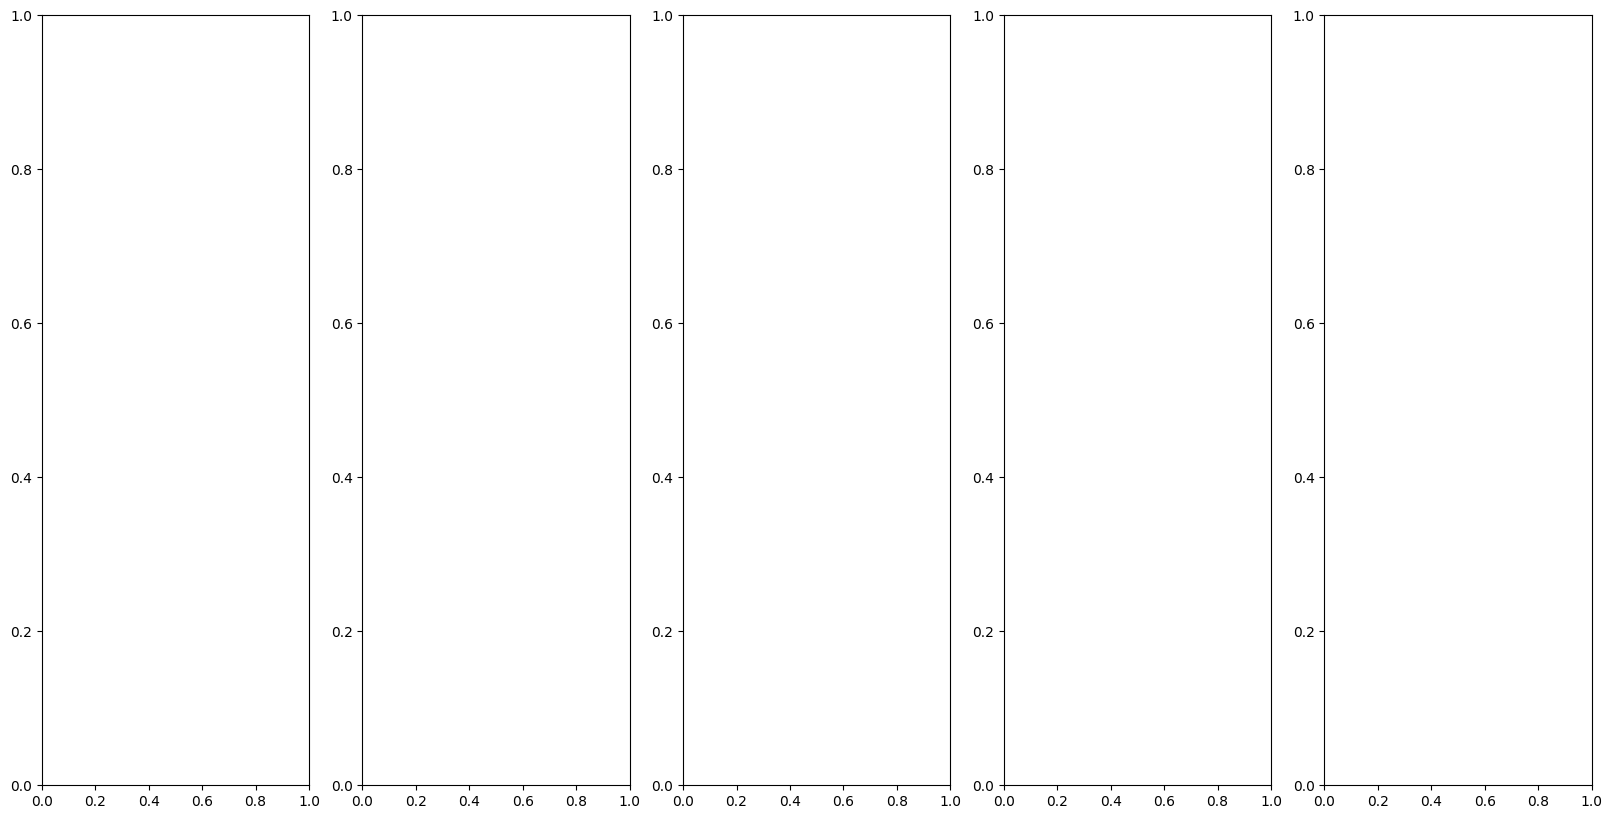


Recommended items for user 45:
- Item 568597022: Hayes slim with similarity score: 0.8263711929321289
Image for item 568597022 not found.
- Item 816563002: Drizzle with similarity score: 0.7207537889480591
Image for item 816563002 not found.
- Item 477107015: Ellen Bikini Clover Mid 3p with similarity score: 0.7128282189369202
Image for item 477107015 not found.
- Item 403448008: GREG tanktop BB 2-p with similarity score: 0.7046922445297241
Image for item 403448008 not found.
- Item 403448010: GREG tanktop BB 2-p with similarity score: 0.7041707038879395
Image for item 403448010 not found.


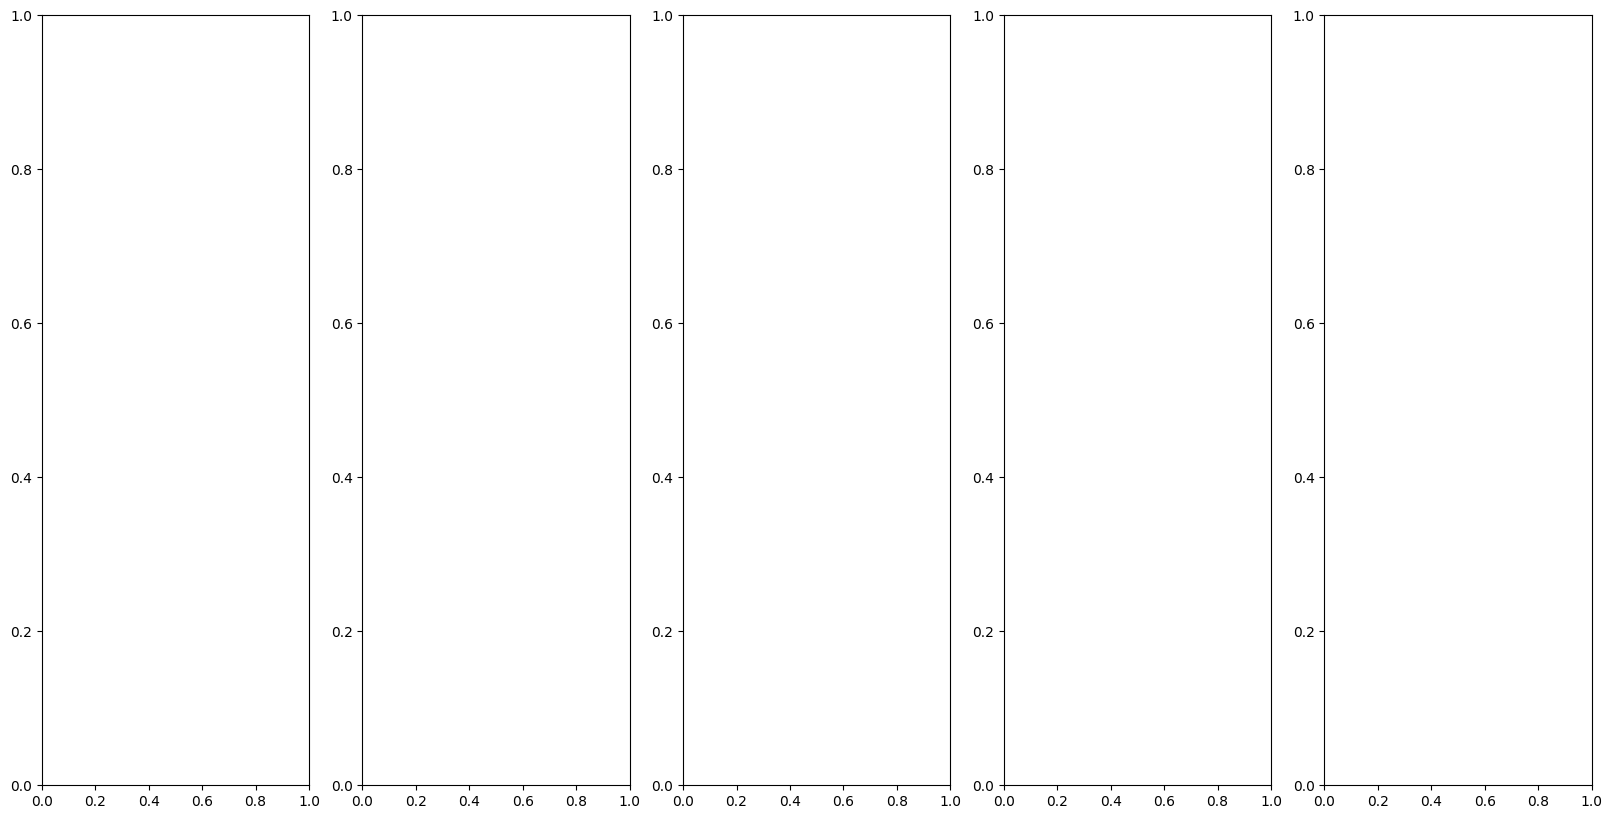

In [27]:
recommend_items(45, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)